# Ensemble Approach

- Approach to build Ensemble Models with Hard- and Softvoting. <br>
- The goal is to further improve the model performance <br>
- The Ensemble Approach gets tested on the Germeval and Hasoc Data in this notebook

In [4]:
%%capture
!pip install transformers
!pip install datasets
!pip install torchvision
!pip install wandb
!pip install ipynb
!pip install s3fs
!pip install nvidia-ml-py3
!pip install sentencepiece

In [5]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
# Check how much memory on the GPU is left and empty cache if needed

import nvidia_smi

nvidia_smi.nvmlInit()

handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)

info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used
     )

nvidia_smi.nvmlShutdown()

Total memory: 11811160064
Free memory: 6654853120
Used memory: 5156306944


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import EarlyStoppingCallback
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report 
from transformers import get_scheduler
from transformers import AdamW
import shutil
import pandas as pd
import json
import s3fs
import os
import torch
from ipynb.fs.full.eval_metrics import *
hello()

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

torch.cuda.is_available()

# Opening JSON file
with open('../credentials.json', 'r') as openfile:
 
    # Reading from json file
    json_object = json.load(openfile)
    key = json_object["key"]
    secret = json_object["secret_key"]
    bucket_name = json_object["bucket_name"]

s3 = s3fs.S3FileSystem(anon=False,key=key,secret=secret)

Hello World!


In [3]:
# Load Germeval Test Data
germ_test = pd.read_csv("../Annotation/Annotation Merging/germeval_2019_test.txt", sep="\t", header=None)
germ_test = germ_test.rename(columns={0: "text", 1: "labels"})
germ_test = germ_test[["text", "labels"]]
germ_test["labels"] = germ_test["labels"].apply(lambda x: 1 if x == "OFFENSE" else (0 if x == "OTHER" else "No_Majority"))
germ_test.head()

,text,labels
0,@JanZimmHHB @mopo Komisch das die RealitÃ¤tsve...,1
1,@faznet @Gruene_Europa @SPDEuropa @CDU CDU ste...,1
2,"@DLFNachrichten Die Gesichter, Namen, Religion...",0
3,@welt Wie verwirrt muss man sein um sich zu we...,1
4,@hacker_1991 @torben_braga Weil die AfD den Fe...,1


In [4]:
# Load Hasoc Test Data
hasoc = pd.read_table("hasoc_de_test_gold.tsv")
hasoc["majority_vote"] = hasoc["task_1"].apply(lambda x: 1 if x == "HOF" else (0 if x == "NOT" else "No_Majority"))
hasoc = hasoc[["text", "majority_vote"]]
hasoc = hasoc.rename(columns={"text": "text", "majority_vote": "labels"})
hasoc = hasoc.dropna()
hasoc.head(2)

,text,labels
0,"Die Grüne Intelligenz Bestie 'Eckhardt', Prang...",1
1,"Das Deutschlandlied, Sinn und Unsinn https:/...",0


In [14]:
hasoc.labels.value_counts()

0    714
1    136
Name: labels, dtype: int64

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [11]:
def ensembling(data, tok1,tok2,tok3,mod1,mod2,mod3):
    print(data.head())
    tokenizer = AutoTokenizer.from_pretrained(tok1)
    tokenizer1 = AutoTokenizer.from_pretrained(tok2)
    tokenizer2 = AutoTokenizer.from_pretrained(tok2)
    # ----- 3. Predict -----#
    # Load test data
    X_test = list(data["text"])
    X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)
    X_test_tokenized1 = tokenizer1(X_test, padding=True, truncation=True, max_length=512)
    X_test_tokenized2 = tokenizer2(X_test, padding=True, truncation=True, max_length=512)

    # Create torch dataset
    test_dataset = Dataset(X_test_tokenized)
    test_dataset1 = Dataset(X_test_tokenized1)
    test_dataset2 = Dataset(X_test_tokenized2)

    # Load trained models
    model = AutoModelForSequenceClassification.from_pretrained(mod1, num_labels=2)
    model1 = AutoModelForSequenceClassification.from_pretrained(mod2, num_labels=2)
    model2 = AutoModelForSequenceClassification.from_pretrained(mod3, num_labels=2)

    # Define test trainer
    test_trainer = Trainer(model)
    test_trainer1 = Trainer(model1)
    test_trainer2 = Trainer(model2)

    # Make prediction
    raw_pred, _, _ = test_trainer.predict(test_dataset)
    raw_pred1, _1, _1 = test_trainer1.predict(test_dataset1)
    raw_pred2, _2, _2 = test_trainer2.predict(test_dataset2)

    # Preprocess raw predictions
    y_pred = np.argmax(raw_pred, axis=1)
    y_pred1 = np.argmax(raw_pred1, axis=1)
    y_pred2 = np.argmax(raw_pred2, axis=1)
    
    # Build Numpy Arrays to be able to do Soft Voting
    sum_array = np.add(raw_pred, raw_pred1)
    sum_array = np.add(sum_array, raw_pred2)

    # Divide 1 by the number of classifiers
    multi = np.multiply(sum_array, 0.33)
    
    # Soft Voting
    y_pred_soft = np.argmax(multi, axis=1)
    
    # Hard Voting
    y_pred_ens = []

    for i in range(len(y_pred)):
        if y_pred[i] + y_pred1[i] + y_pred2[i]  > 1 :
            res = 1
            y_pred_ens.append(res)
        else:
            res = 0
            y_pred_ens.append(res)

    y_pred_ens = np.array(y_pred_ens)
    
    #y_pred = y_pred_ens
    y_pred = y_pred_soft

    from sklearn.metrics import f1_score

    test_list = data["labels"].tolist()
    test_list = np.array(test_list)

        # Compute Evaluation Metrics
    f = f1_multiclass(test_list, y_pred)
    p = p_multiclass(test_list, y_pred)
    r = recall_multiclass(test_list, y_pred)
    a = accuracy_score(test_list, y_pred)
    ba = balanced_accuracy_score(test_list, y_pred)
    prs = precision_recall_fscore_support(test_list, y_pred)
    m = matthews_corrcoef(test_list,y_pred)

    results = {}
    results["acc"] = a
    results["f1"] = f
    results["precision"] = p
    results["recall"] = r
    results["bal_acc"] = ba
    results["prfs"] = prs
    results["mcc"] = m

    prepare_results(results)
    result_df = dict_to_df(results)
    #result_df.to_csv(f"./Ensemble_Results/Ensemble_Own_Data/Ensemble_3_results_hard_voting.csv")
    print(result_df)
    class_rep = classification_report(test_list, y_pred,target_names=["HOF", "NOT"])
    cm = confusion_matrix(test_list, y_pred,)
    ax = plt.subplot()
    cm_plot = sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Greens');
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['NOT', 'HOF'])
    ax.yaxis.set_ticklabels(['NOT', 'HOF']);
    #cm_plot.figure.savefig(f"./Ensemble_Results/Ensemble_Own_Data/CM_Ensemble_3_results_hard_voting.png")
    
    ######## Now Hard Voting
    print("Now Hard Voting Results:")
        #y_pred = y_pred_ens
    y_pred = y_pred_ens

    test_list = data["labels"].tolist()
    test_list = np.array(test_list)

        # Compute Evaluation Metrics
    f = f1_multiclass(test_list, y_pred)
    p = p_multiclass(test_list, y_pred)
    r = recall_multiclass(test_list, y_pred)
    a = accuracy_score(test_list, y_pred)
    ba = balanced_accuracy_score(test_list, y_pred)
    prs = precision_recall_fscore_support(test_list, y_pred)
    m = matthews_corrcoef(test_list,y_pred)

    results = {}
    results["acc"] = a
    results["f1"] = f
    results["precision"] = p
    results["recall"] = r
    results["bal_acc"] = ba
    results["prfs"] = prs
    results["mcc"] = m

    prepare_results(results)
    result_df = dict_to_df(results)
    #result_df.to_csv(f"./Ensemble_Results/Ensemble_Own_Data/Ensemble_3_results_hard_voting.csv")
    print(result_df)
    class_rep = classification_report(test_list, y_pred,target_names=["HOF", "NOT"])
    cm = confusion_matrix(test_list, y_pred,)
    ax = plt.subplot()
    cm_plot = sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Greens');
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['NOT', 'HOF'])
    ax.yaxis.set_ticklabels(['NOT', 'HOF']);
    #cm_plot.figure.savefig(f"./Ensemble_Results/Ensemble_Own_Data/CM_Ensemble_3_results_hard_voting.png")

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained("EIStakovskii/german_toxicity_classifier_plus_v2")
#tokenizer1 = AutoTokenizer.from_pretrained("german-nlp-group/electra-base-german-uncased")
#tokenizer2 = AutoTokenizer.from_pretrained("deepset/gbert-base")
#tokenizer3 = AutoTokenizer.from_pretrained("T-Systems-onsite/cross-en-de-roberta-sentence-transformer")
#tokenizer4 = AutoTokenizer.from_pretrained("bert-base-german-dbmdz-uncased")

tokenizer1 = "EIStakovskii/german_toxicity_classifier_plus_v2"
tokenizer2 = "german-nlp-group/electra-base-german-uncased"
tokenizer3= "bert-base-german-dbmdz-uncased"

model1 = "mox/german_toxicity_classifier_offensive_language_politicians"
model2 = "mox/electra_german_uncased_offensive_language_politicians"
model3 = "mox/gbert_base_offensive_language_politicians"

# Test Ensemble Model on the specified dataset, in this case, the HASOC Test Dataset
ensembling(hasoc, tokenizer1, tokenizer2, tokenizer3, model1, model2, model3)

# Predict only single model

                             1
0                             
acc                   0.774118
bal_acc               0.591737
mcc                   0.179311
f1_macro              0.589537
f1_micro              0.774118
f1_weighted           0.776708
precision_macro       0.587622
precision_micro       0.774118
precision_weighted    0.779427
recall_macro          0.591737
recall_micro          0.774118
recall_weighted       0.774118
precision_class_0     0.869688
precision_class_1     0.305556
recall_class_0        0.859944
recall_class_1        0.323529
f1_score_class_0      0.864789
f1_score_class_1      0.314286
sample_class_0      714.000000
sample_class_1      136.000000


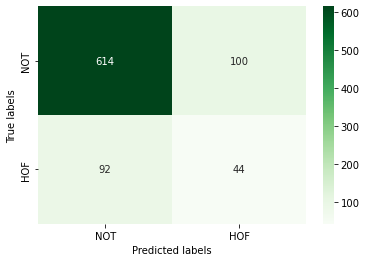

In [59]:
# For experimentation, we also tried out single models, to see it the perform better or not

model_name = "tsystems_on_hasoc_test"
#tokenizer = AutoTokenizer.from_pretrained("EIStakovskii/german_toxicity_classifier_plus_v2")
#tokenizer = AutoTokenizer.from_pretrained("german-nlp-group/electra-base-german-uncased")
#tokenizer = AutoTokenizer.from_pretrained("deepset/gbert-base")
tokenizer = AutoTokenizer.from_pretrained("T-Systems-onsite/cross-en-de-roberta-sentence-transformer")
#tokenizer = AutoTokenizer.from_pretrained("bert-base-german-dbmdz-uncased")
#tokenizer = AutoTokenizer.from_pretrained("shahrukhx01/gbert-hasoc-german-2019")
#tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

X_test = list(hasoc["text"])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Load trained model
#model = AutoModelForSequenceClassification.from_pretrained(f"BEST_Model_Electra_with_Germeval_training_run5_best_model", num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained(f"TSystems_HASOC_AND_GERMEVAL_best_model", num_labels=2)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

from sklearn.metrics import f1_score

test_list = hasoc["labels"].tolist()
test_list = np.array(test_list)

    # Compute Evaluation Metrics
f = f1_multiclass(test_list, y_pred)
p = p_multiclass(test_list, y_pred)
r = recall_multiclass(test_list, y_pred)
a = accuracy_score(test_list, y_pred)
ba = balanced_accuracy_score(test_list, y_pred)
prs = precision_recall_fscore_support(test_list, y_pred)
m = matthews_corrcoef(test_list,y_pred)

results = {}
results["acc"] = a
results["f1"] = f
results["precision"] = p
results["recall"] = r
results["bal_acc"] = ba
results["prfs"] = prs
results["mcc"] = m

prepare_results(results)
result_df = dict_to_df(results)
#result_df.to_csv(f"Germeval_{model_name}_results.csv")
print(result_df)
class_rep = classification_report(test_list, y_pred,target_names=["HOF", "NOT"])
cm = confusion_matrix(test_list, y_pred,)
ax = plt.subplot()
cm_plot = sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Greens');
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['NOT', 'HOF'])
ax.yaxis.set_ticklabels(['NOT', 'HOF']);
#cm_plot.figure.savefig(f"{ansatz}_best_model/confusion_matrix_{train_index}.png")